In [35]:
# import libraries
import pandas as pd 
import matplotlib.pyplot as plt

In [36]:
# load the data
data_url_1 = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
lefthanded_data = pd.read_csv(data_url_1)

In [37]:
lefthanded_data

,Age,Male,Female
0,10,12.717558,12.198041
1,11,15.318830,11.144804
2,12,14.808281,11.549240
3,13,13.793744,11.276442
4,14,15.156304,11.572906
...,...,...,...
72,82,7.350204,4.874899
73,83,6.471204,5.672536
74,84,6.510858,5.774881
75,85,7.337968,7.051459


In [38]:
lefthanded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     77 non-null     int64  
 1   Male    77 non-null     float64
 2   Female  77 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.9 KB


## Checking for Male and Female left-handed people percentage

Text(0, 0.5, 'Percentage')

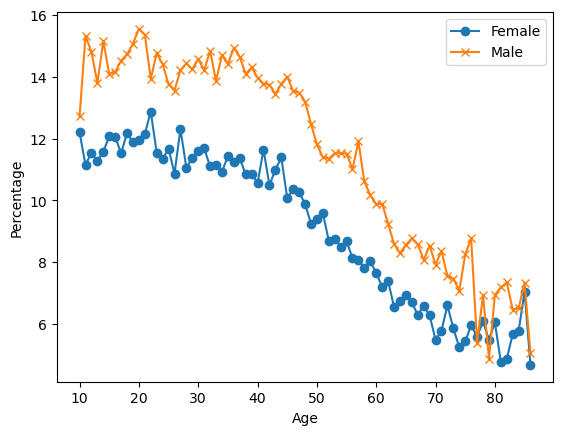

In [39]:
# plot male and female left-handedness rates vs. age
%matplotlib inline
fig, ax = plt.subplots() # create figure and axis objects
ax.plot(lefthanded_data.Age, lefthanded_data.Female,label='Female', marker = 'o') # plot "Female" vs. "Age"
ax.plot(lefthanded_data.Age, lefthanded_data.Male, label='Male', marker = 'x') # plot "Male" vs. "Age"
ax.legend() # add a legend
ax.set_xlabel('Age')
ax.set_ylabel('Percentage')

## Checking for mean of left-handed people over the years

In [40]:
# create a new column for birth year of each age
lefthanded_data['Birth_year'] = 1986 - lefthanded_data.Age

In [41]:
# create a new column for the average of male and female
lefthanded_data['Mean_lh'] = (lefthanded_data.Male+lefthanded_data.Female)/2

Text(0, 0.5, 'Mean')

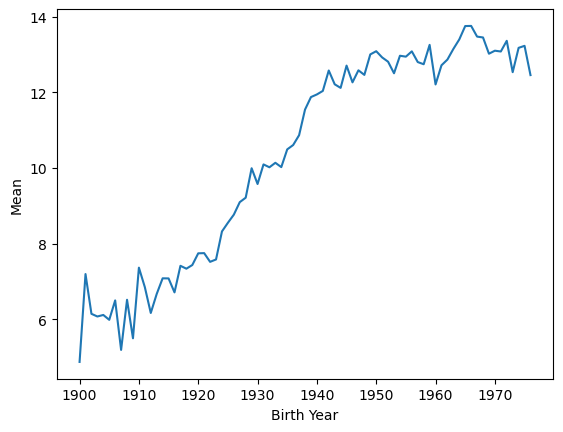

In [42]:
# create a plot of the 'Mean_lh' column vs. 'Birth_year'
fig, ax = plt.subplots()
ax.plot(lefthanded_data.Birth_year, lefthanded_data.Mean_lh) # plot 'Mean_lh' vs. 'Birth_year'
ax.set_xlabel('Birth Year') # set the x label for the plot
ax.set_ylabel('Mean') # set the y label for the plot

## Applying Bayesian Rule

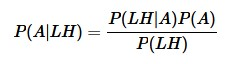

In [43]:
import numpy as np

# create a function for P(LH | A)
def P_lh_given_A(ages_of_death, study_year = 1990):
    """ P(Left-handed | age of death), calculated based on the reported rates of left-handedness.
    Inputs: age of death, study_year
    Returns: probability of left-handedness given that a subject died in `study_year` at age `age_of_death` """
    
    # Use the mean of the 10 neighbouring points for rates before and after the start 
    early_1900s_rate = lefthanded_data['Mean_lh'][-10:].mean()
    late_1900s_rate = lefthanded_data['Mean_lh'][:10].mean()
    middle_rates = lefthanded_data.loc[lefthanded_data['Birth_year'].isin(study_year - ages_of_death)]['Mean_lh']
    
    youngest_age = study_year - 1986 + 10 # the youngest age in the NatGeo dataset is 10
    oldest_age = study_year - 1986 + 86 # the oldest age in the NatGeo dataset is 86
    
    P_return = np.zeros(ages_of_death.shape)  # create an empty array to store the results
    # extract rate of left-handedness for people of age age_of_death
    P_return[ages_of_death > oldest_age] = early_1900s_rate / 100
    P_return[ages_of_death < youngest_age] = late_1900s_rate / 100
    P_return[np.logical_and((ages_of_death <= oldest_age), (ages_of_death >= youngest_age))] = middle_rates / 100
 
    return P_return

## When does the normal death occurs

Text(0, 0.5, 'Frequency')

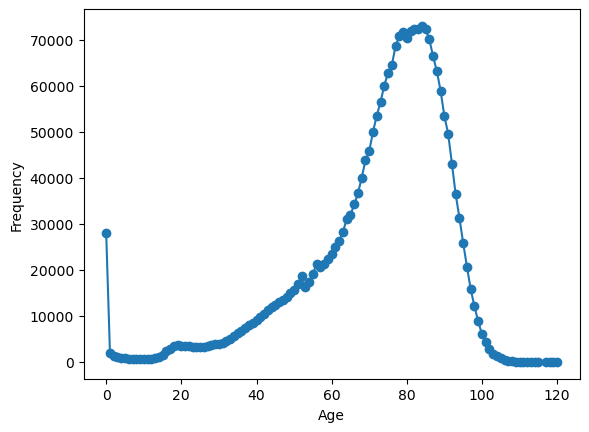

In [44]:
# Death distribution data for the United States in 1999
data_url_2 = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"

# load death distribution data
death_distribution_data = pd.read_csv(data_url_2, sep='\t', skiprows=[1])

# drop NaN values from the `Both Sexes` column
death_distribution_data = death_distribution_data.dropna(subset=['Both Sexes'])

# plot number of people who died as a function of age
fig, ax = plt.subplots()
ax.plot(death_distribution_data['Age'], death_distribution_data['Both Sexes'], marker='o') # plot 'Both Sexes' vs. 'Age'
ax.set_xlabel('Age') 
ax.set_ylabel('Frequency')

## The Overall probability of being left-handed

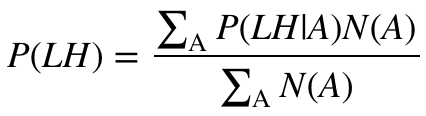

In [45]:
def P_lh(death_distribution_data, study_year = 1990): # sum over P_lh for each age group
    """ Overall probability of being left-handed if you died in the study year
    P_lh = P(LH | Age of death) P(Age of death) + P(LH | not A) P(not A) = sum over ages 
    Input: dataframe of death distribution data
    Output: P(LH), a single floating point number """
    p_list = death_distribution_data['Both Sexes']*P_lh_given_A(death_distribution_data['Age'], study_year)
    p = np.sum(p_list)
    return p/np.sum(death_distribution_data['Both Sexes']) # normalize to total number of people in distribution

print(P_lh(death_distribution_data))

0.07766387615350638


## 1) Dying while being left handed

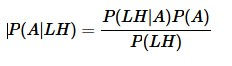

In [46]:
def P_A_given_lh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're left-handed """
    P_A = death_distribution_data['Both Sexes'][ages_of_death] / np.sum(death_distribution_data['Both Sexes'])
    P_left = P_lh(death_distribution_data, study_year) # use P_lh function to get probability of left-handedness overall
    P_lh_A = P_lh_given_A(ages_of_death, study_year) # use P_lh_given_A to get probability of left-handedness for a certain age
    return P_lh_A*P_A/P_left

## 2) Dying while being right handed

In [47]:
def P_A_given_rh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're right-handed """
    P_A = death_distribution_data['Both Sexes'][ages_of_death] / np.sum(death_distribution_data['Both Sexes'])
    P_right = 1- P_lh(death_distribution_data, study_year) # either you're left-handed or right-handed, so these sum to 1
    P_rh_A = 1-P_lh_given_A(ages_of_death, study_year) # these also sum to 1 
    return P_rh_A*P_A/P_right

## Plotting the distributions of conditional probabilities

Text(0, 0.5, 'Probability of being age A at death')

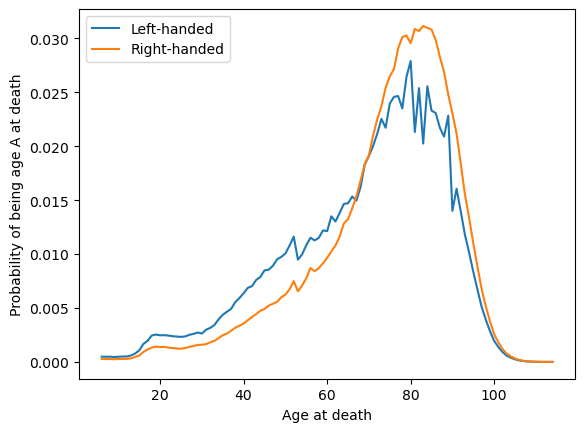

In [48]:
ages = np.arange(6,115,1) # make a list of ages of death to plot

# for each age, calculate the probability of being left- or right-handed
left_handed_probability = P_A_given_lh(ages, death_distribution_data)
right_handed_probability = P_A_given_rh(ages, death_distribution_data)

fig, ax = plt.subplots() # create figure and axis objects
ax.plot(ages, left_handed_probability, label = "Left-handed")
ax.plot(ages, right_handed_probability, label = "Right-handed")
ax.legend()
ax.set_xlabel("Age at death")
ax.set_ylabel(r"Probability of being age A at death")

## Age of left-handed people and right handed people during death

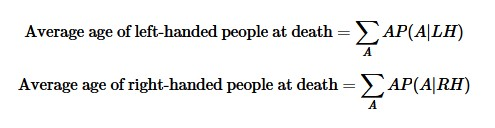

In [49]:
# calculate average ages for left-handed and right-handed groups
# use np.array so that two arrays can be multiplied
average_lh_age =  np.nansum(ages*np.array(left_handed_probability))
average_rh_age =  np.nansum(ages*np.array(right_handed_probability))

# print the average ages for each group
print(round(average_lh_age,1))
print(round(average_rh_age,1))

# print the difference between the average ages
print("The difference in average ages is " + str(round(average_rh_age - average_lh_age, 1)) + " years.")

67.2
72.8
The difference in average ages is 5.5 years.


## Final comments

In [50]:
# loop through ages, calculating the probability of being left- or right-handed
left_handed_probability_2018 = P_A_given_lh(ages, death_distribution_data, study_year = 2018)
right_handed_probability_2018 = P_A_given_rh(ages, death_distribution_data, study_year = 2018)
    
# calculate average ages for left-handed and right-handed groups
average_lh_age_2018 =  np.nansum(ages*np.array(left_handed_probability_2018))
average_rh_age_2018 =  np.nansum(ages*np.array(right_handed_probability_2018))

print("The difference in average ages is " + 
      str(round(average_rh_age_2018 - average_lh_age_2018, 1)) + " years.")

The difference in average ages is 2.3 years.
